In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
import sampers
import mscthesis
import plotly.graph_objects as pgo
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import pairwise_distances
import time

# Sampers

In [3]:
sampers_scale = "east"

In [4]:
# Zones
sampers_zones = sampers.read_shp(sampers.shps[sampers_scale])

# ODM
sampers_odm = sampers.read_odm(sampers.odms[sampers_scale]).set_index(['ozone', 'dzone'])['total']

# Drop unknown zones (ie. trips between zones that are not part of shapefile)
# If ODM does not contain trips between regions they are set to 0.0
sampers_odm = sampers_odm.reindex(
    pd.MultiIndex.from_product([
        sampers_zones['zone'],
        sampers_zones['zone'],
    ]),
    fill_value=0.0,
)

# Normalize
sampers_odm = sampers_odm / sampers_odm.sum()

print("Sampers zones\t", sampers_zones.shape)
print("Sampers ODM\t", sampers_odm.shape)

Sampers zones	 (3038, 5)
Sampers ODM	 (9229444,)


In [5]:
# Distances between regions
sampers_zonesx = sampers_zones.set_index('zone')
distances = pairwise_distances(
    list(zip(
        sampers_zonesx.geometry.centroid.x.to_list(),
        sampers_zonesx.geometry.centroid.y.to_list(),
    ))
)
distancesx = pd.DataFrame(
    distances / 1000,
    columns=sampers_zonesx.index,
    index=sampers_zonesx.index,
).stack().reindex(sampers_odm.index)

print("Sampers distances\t", distancesx.shape)

Sampers distances	 (9229444,)


# Visits

In [93]:
visits = pd.read_csv('./../../dbs/sweden/visits-song-infered-timeslots-60w.csv').set_index('userid')

### Remove users not in sampling zone

In [94]:
if sampers_scale in sampers.bbox:
    # Read home locations
    home_locations = pd.read_csv('./../../dbs/sweden/homelocations.csv').set_index('userid')
    home_locations = gpd.GeoDataFrame(
        home_locations,
        crs="EPSG:3006",
        geometry=gpd.points_from_xy(home_locations.x, home_locations.y),
    )
    # Remove home locations not in sampling zone
    print("Homelocations before filtering\t", home_locations.shape)
    home_locations = gpd.sjoin(home_locations, sampers.bbox[sampers_scale])
    print("Homelocations after filtering\t", home_locations.shape)
    # Remove users not in sampling zone
    print("Visits before filtering\t", visits.shape)
    visits = visits[visits.index.isin(home_locations.index)]
    print("Visits after filtering\t", visits.shape)
else:
    print("Not removing users due to no bounding box", sampers_scale)

Homelocations before filtering	 (4056, 3)
Homelocations after filtering	 (1951, 6)
Visits before filtering	 (6474279, 6)
Visits after filtering	 (3090200, 6)


In [95]:
visits = gpd.GeoDataFrame(
    visits,
    crs="EPSG:4326",
    geometry=gpd.points_from_xy(visits.longitude, visits.latitude),
)
visits = visits.to_crs(sampers_zones.crs)
print("Visits\t", visits.shape)

Visits	 (3090200, 7)


In [96]:
# Remove consecutive region visits
size_before = visits.shape[0]
visits = mscthesis.remove_consecutive_region_visits(visits)
print("Visits removed due to consecutive regions\t", size_before - visits.shape[0])

Visits removed due to consecutive regions	 247


In [97]:
# Align regions to Sampers zones
regional_visits = visits[visits.kind == 'region']
print("Regional visits before align\t", regional_visits.shape)
user_regions = regional_visits.groupby(['userid', 'region']).head(1)
print("User regions before align\t", user_regions.shape)
user_zones = gpd.sjoin(user_regions, sampers_zones, op='intersects')[['region', 'zone']]
print("User zones after align\t\t", user_zones.shape)
regional_visitsx = user_zones.merge(regional_visits, on=['userid', 'region'])
print("Regional visits after align\t", regional_visitsx.shape)
print()
print("Regional visits lost during align\t", regional_visits.shape[0] - regional_visitsx.shape[0])

Regional visits before align	 (2929734, 7)
User regions before align	 (132692, 7)
User zones after align		 (101925, 2)
Regional visits after align	 (2669992, 8)

Regional visits lost during align	 259742


In [98]:
# Align points to Sampers zones
point_visits = visits[visits.kind == 'point']
print("Point visits before align\t", point_visits.shape)
point_visitsx = gpd.sjoin(point_visits, sampers_zones, op='intersects')
print("Point visits after align\t", point_visitsx.shape)
print()
print("Point visits lost during align\t", point_visits.shape[0] - point_visitsx.shape[0])

Point visits before align	 (160219, 7)
Point visits after align	 (138599, 12)

Point visits lost during align	 21620


In [99]:
# Recombine
visitsx = pd.concat([
    regional_visitsx[['day', 'timeslot', 'zone']],
    point_visitsx[['day', 'timeslot', 'zone']]
])
# Reorder based on index (userid, day, timeslot) to get visits in chonological order
visitsx = visitsx.reset_index().set_index(['userid', 'day', 'timeslot']).sort_index().reset_index().set_index('userid')
print("Visits after align\t", visitsx.shape)

Visits after align	 (2808591, 3)


In [100]:
# Create ODM from visits
twitter_trips = mscthesis.visit_gaps(visitsx[['zone']])
twitter_odm = twitter_trips.groupby(['zone_origin', 'zone_destination']).size()
print("Twitter ODM before reindex\t", twitter_odm.shape)

# Reindex to Sampers ODM
twitter_odm = twitter_odm.reindex(sampers_odm.index, fill_value=0)
print("Twitter ODM after reindex\t", twitter_odm.shape)

# Normalize
twitter_odm = twitter_odm / twitter_odm.sum()

Twitter ODM before reindex	 (300863,)
Twitter ODM after reindex	 (9229444,)


# TODO: Distance filter for national scale

# Visual comparison

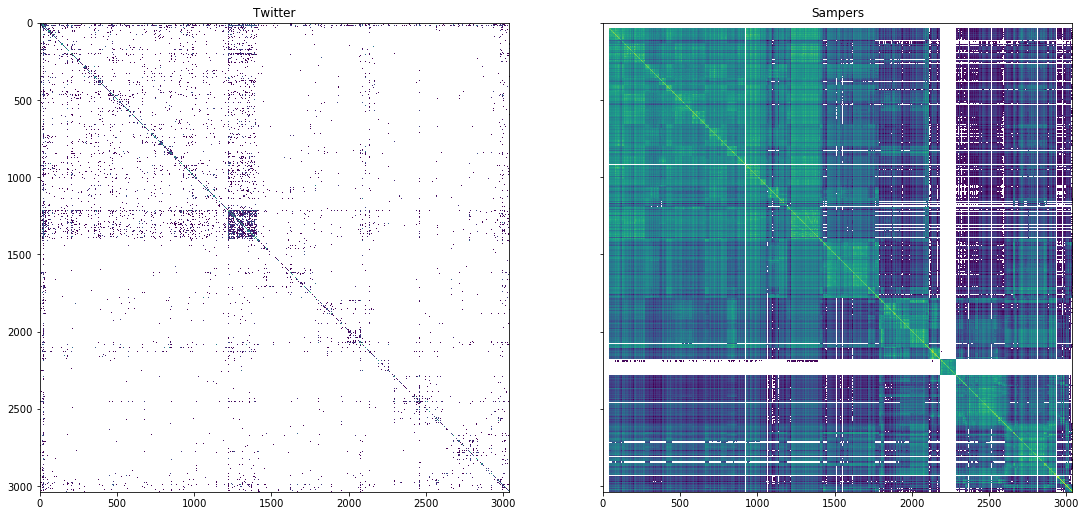

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(twitter_odm.unstack().values, norm = mpl.colors.LogNorm())
ax2.imshow(sampers_odm.unstack().values, norm = mpl.colors.LogNorm())
ax1.set_title('Twitter')
ax2.set_title('Sampers')
plt.show()

In [102]:
score = mscthesis.spssim(sampers_odm, twitter_odm, distancesx, nquantiles=100)

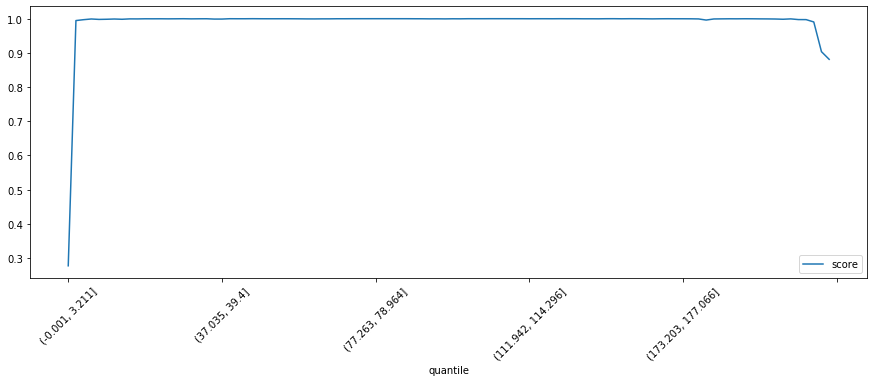

In [103]:
score.plot(figsize=(15,5), rot=45)

In [104]:
score.describe()

,score
count,100.000000
mean,0.989996
std,0.073574
min,0.277310
25%,0.999404
50%,0.999717
75%,0.999856
max,0.999968


In [105]:
score

,score
quantile,
"(-0.001, 3.211]",0.277310
"(3.211, 5.192]",0.994515
"(5.192, 6.939]",0.997085
"(6.939, 8.647]",0.999116
"(8.647, 10.313]",0.997877
...,...
"(277.455, 291.861]",0.997383
"(291.861, 312.377]",0.997276
"(312.377, 348.792]",0.990404
